In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
link = 'drive/My Drive/Colab Notebooks/APS360/'
print(device)

cuda:0


In [3]:
class ImageFolder(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolder, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_index = (original_tuple + (index,))
        return tuple_with_index

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    

def get_data_loader(batch_size, position="samePos"):
    
    transform = transforms.Compose([transforms.Resize((150, 250)), transforms.ToTensor()])
    
    ori_data = torchvision.datasets.ImageFolder(link+'resized_images/wide', transform = transform)
    
    if position == "diffPos":
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/diffPos/3', \
                                                transform = transform)
    else:
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/samePos/3', \
                                                transform = transform)
        
        
    labeled_data = ConcatDataset(ori_data, data)
    
    trainLen = int(0.6*len(labeled_data))
    valLen = int(0.2*len(labeled_data))
    testLen = int(0.2*len(labeled_data))
    
    train_data, val_data, test_data = torch.utils.data.random_split \
    (labeled_data, [trainLen, valLen, testLen])
    
    train_data_loader = torch.utils.data.DataLoader(train_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    val_data_loader = torch.utils.data.DataLoader(val_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    test_data_loader = torch.utils.data.DataLoader(test_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    
    return train_data_loader, val_data_loader, test_data_loader

# NOTE: THIS ONLY USES ONE FOLDER!
train_data_loader, val_data_loader, test_data_loader = get_data_loader(1)
print(len(train_data_loader), len(val_data_loader), len(test_data_loader))

825 275 275


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 10, 5, stride=2),
            nn.BatchNorm2d(10, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(10, 16, (3, 5), stride=2),
            nn.BatchNorm2d(16, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(8640, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)
        out = torch.squeeze(self.fc(out))
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 32, (18,30)),
            nn.BatchNorm2d(32, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, 13, stride=2, padding=6, output_padding=1),
            nn.BatchNorm2d(16, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 16, 9, stride=2, padding=4, output_padding=1),
            nn.BatchNorm2d(16, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(8, 0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(8, 3, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), 100, 1, 1)
        out = self.model(x)
        return out

In [0]:
def conv3x3(in_channels, out_channels, stride=1):
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         stride=stride, padding=1, bias=False)

class testResNetBlocks(nn.Module):

    def load_weights(self, layername):
        an_builtin = models.resnet18(pretrained=True) # Loads the pretrained model weights
        
        own_state = self.state_dict()
        
        for (name, layer) in an_builtin._modules.items():
            if name == layername:
                self.conv1.weight = layer[0]._modules['conv1'].weight
                self.conv2.weight = layer[0]._modules['conv2'].weight
            if layername == name+"-":
                self.conv1.weight = layer[1]._modules['conv1'].weight
                self.conv2.weight = layer[1]._modules['conv2'].weight
    
    def __init__(self, in_channels, out_channels, layername, stride=1, downsample=None):
        super(testResNetBlocks, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.load_weights(layername)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [0]:
class DilatedResNet(nn.Module):
    def __init__(self, block):
        super(DilatedResNet, self).__init__()
        
        self.in_channels = 64
        self.bottleneck_channels = 16
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.layers1 = self.make_layer(block, 64, "layer1")
#         self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
#         self.layers2 = self.make_layer(block, 128, "layer2")
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, self.bottleneck_channels, 3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
#             nn.ConvTranspose2d(16, 3, 3, stride=1, padding=2, output_padding = 1, dilation=2),
#             nn.BatchNorm2d(3),
            nn.ConvTranspose2d(self.bottleneck_channels, 3, 3, padding=1),
#             nn.ConvTranspose2d(32, 3, 3)
            nn.Sigmoid()
        )
    
    def make_layer(self, block, out_channels, layername, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, layername, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, 2):
            layers.append(block(out_channels, out_channels, layername+"-"))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layers1(x)
#         x = self.conv2(x)
#         x = self.layers2(x)
        x = self.decoder(x)
        return x

In [0]:
def get_accuracy(model, data_loader, criterion):
    total_loss, total_err, total_epoch = 0.0, 0.0, 0
    
    i = 0
    for original, watermarked in data_loader:
        ori_img, _ = original
        water_img, _ = watermarked
        ori_img = ori_img.cuda()
        water_img = water_img.cuda()
        
#         myfeatures = myfeature_model(water_img)
        recon = model(water_img)
        loss = criterion(recon, ori_img)
        
        correct = (ori_img != recon).sum().item()
        total_err += correct
        total_loss += loss.item()
        total_epoch += len(ori_img)
        i+=1
        
        if i > 10:
            break
    
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i+1)
    
    return err, loss

In [0]:
def train(generator, discriminator, lr=0.001, num_epochs=5):
    criterion = nn.BCEWithLogitsLoss().cuda()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

    num_test_samples = 64

    for epoch in range(num_epochs):
        # label that we are using both models 
        generator.train()
        discriminator.train()


        for original, watermarkedimg in train_loader:
            # === Train the Discriminator ===
            ori_img, _ = original
            watermarked, _ = watermarkedimg
            ori_img = ori_img.cuda()
            watermarked = watermarked.cuda()
            fake_images = generator(watermarked)
#             print(watermarked.is_cuda, fake_images.is_cuda)
            inputs = torch.cat([ori_img, fake_images])
            labels = torch.cat([torch.zeros(ori_img.size(0)), # real
                                torch.ones(ori_img.size(0))]).cuda() # fake
            
            discriminator.zero_grad()
            d_outputs = discriminator(inputs)
#             print(d_outputs.is_cuda, labels.is_cuda)
            d_loss = criterion(d_outputs, labels)
            d_loss.backward()
            d_optimizer.step()

            # === Train the Generator ===
            for _ in range(3):
                fake_images = generator(watermarked)
                outputs = discriminator(fake_images)

                generator.zero_grad()
                g_loss = criterion(outputs, torch.cuda.FloatTensor(ori_img.size(0)).fill_(0))
                g_loss.backward()
                g_optimizer.step()

        scores = torch.sigmoid(d_outputs)
        real_score = scores[:ori_img.size(0)].data.mean()
        fake_score = scores[ori_img.size(0):].data.mean()


        print('Epoch [%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              'D(x): %.2f, D(G(z)): %.2f' 
              % (epoch + 1, num_epochs, d_loss.item(), g_loss.item(), real_score, fake_score))
        
        # plot images
        generator.eval()
        discriminator.eval()
        original, watermarked = next(iter(test_data_loader))
        water_img, _ = watermarked
        test_images = generator(water_img.cuda())
        plt.figure(figsize=(9, 3))
        im = test_images[0].data.cpu().numpy().reshape(3, 150, 250)
        im = np.transpose(im, [1,2,0])
        plt.imshow(im)
        plt.show()

Epoch [1/100], d_loss: 0.1317, g_loss: 2.1667, D(x): 0.07, D(G(z)): 1.00


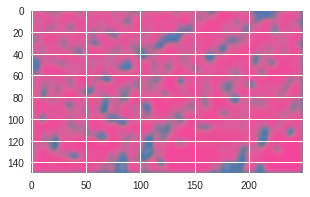

Epoch [2/100], d_loss: 0.0000, g_loss: 6.8436, D(x): 0.00, D(G(z)): 1.00


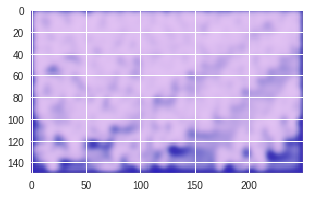

In [0]:
discriminator = Discriminator()
generator = DilatedResNet(testResNetBlocks)

discriminator.to(device)
generator.to(device)
train(generator, discriminator, lr =0.02, num_epochs=100)